In [ ]:
import pandas as pd
import numpy as np
import datetime as dt

data=pd.read_csv('/content/drive/MyDrive/timegan-forecast/data/online_retail_listing.csv')
#change date to datetime format
#data["ORDERDATE"] = pd.to_datetime(data["ORDERDATE"])
#remove missing values
data=data.dropna()
#remove negative value, negative value are returned item
data1 = data[~data["Invoice"].str.contains("C", na = False)]
data1.loc[:, 'InvoiceDate']=pd.to_datetime(data1.loc[:, 'InvoiceDate'], format='%d.%m.%Y %H:%M')
data1


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom
...,...,...,...,...,...,...,...,...
1048570,580501,23284,DOORMAT KEEP CALM AND COME IN,2,2011-12-04 13:00:00,8.25,14546.0,United Kingdom
1048571,580501,22507,MEMO BOARD RETROSPOT DESIGN,3,2011-12-04 13:00:00,4.95,14546.0,United Kingdom
1048572,580502,22469,HEART OF WICKER SMALL,3,2011-12-04 13:15:00,1.65,16931.0,United Kingdom
1048573,580502,23489,VINTAGE BELLS GARLAND,2,2011-12-04 13:15:00,2.89,16931.0,United Kingdom


In [1]:
#recency
print("Min Date", data1["InvoiceDate"].min(), "Max Date", data1["InvoiceDate"].max())
recency1 = (dt.datetime(2011, 12, 4) - data1.groupby("Customer ID").agg({"InvoiceDate":"max"})).rename(columns = {"InvoiceDate":"Recency"})
recency1["Recency"] = recency1["Recency"].apply(lambda x: x.days)
recency1

NameError: name 'data1' is not defined

In [ ]:
#Frequency
freq1 = data.groupby("Customer ID").agg({"InvoiceDate":"nunique"}).rename(columns={"InvoiceDate": "Frequency"})
freq1

,Frequency
Customer ID,
12346.0,17
12347.0,7
12348.0,5
12349.0,5
12350.0,1
...,...
18283.0,21
18284.0,2
18285.0,1


In [2]:
#monetaray
data1["TotalPrice"] = data1["Quantity"] * data1["Price"]
monetary1 = data1.groupby("Customer ID").agg({"TotalPrice":"sum"}).rename(columns={"TotalPrice":"Monetary"})
monetary1

NameError: name 'data1' is not defined

In [ ]:
rfm1 = pd.concat([recency1, freq1, monetary1],  axis=1)
rfm1=rfm1.dropna()
rfm1

,Recency,Frequency,Monetary
Customer ID,,,
12346.0,319.0,17,77556.46
12347.0,33.0,7,5408.50
12348.0,69.0,5,2019.40
12349.0,12.0,5,4428.69
12350.0,304.0,1,334.40
...,...,...,...
18283.0,3.0,21,2528.65
18284.0,425.0,2,461.68
18285.0,654.0,1,427.00


In [ ]:
#assign rfm score by quantile of value to 1-5 label
rfm1["RecencyScore"] = pd.qcut(rfm1["Recency"], 5, labels = [5, 4 , 3, 2, 1])
rfm1["FrequencyScore"]= pd.qcut(rfm1["Frequency"].rank(method="first"),5, labels=[1,2,3,4,5])
rfm1["MonetaryScore"] = pd.qcut(rfm1['Monetary'], 5, labels = [1, 2, 3, 4, 5])
#merge the frm score
rfm1["RFM_SCORE"] = (rfm1['RecencyScore'].astype(str) +
                     rfm1['FrequencyScore'].astype(str) +
                     rfm1['MonetaryScore'].astype(str))


#segmentation map of rfm by regex
#seg_map = {
 #   r'[1-2][1-2]': 'Lost',
  #  r'[1-2][3-4]': 'At Risk',
   # r'[1-2]5': 'Can\'t Loose',
    #r'3[1-2]': 'Promising',
   # r'33': 'Promising',
   # r'[3-4][4-5]': 'Potential',
   # r'41': 'Promising',
   # r'51': 'Promising',
   # r'[4-5][2-3]': 'Potential',
   # r'5[4-5]': 'Potential'
#}

#rfm1['Segment'] = rfm1['RecencyScore'].astype(str) + rfm1['FrequencyScore'].astype(str)
#rfm1['Segment'] = rfm1['Segment'].replace(seg_map, regex=True)

rfm1

,Recency,Frequency,Monetary,RecencyScore,FrequencyScore,MonetaryScore,RFM_SCORE
Customer ID,,,,,,,
12346.0,319.0,17,77556.46,2,5,5,255
12347.0,33.0,7,5408.50,4,4,5,445
12348.0,69.0,5,2019.40,3,3,4,334
12349.0,12.0,5,4428.69,5,3,5,535
12350.0,304.0,1,334.40,2,1,2,212
...,...,...,...,...,...,...,...
18283.0,3.0,21,2528.65,5,5,4,554
18284.0,425.0,2,461.68,1,2,2,122
18285.0,654.0,1,427.00,1,2,2,122


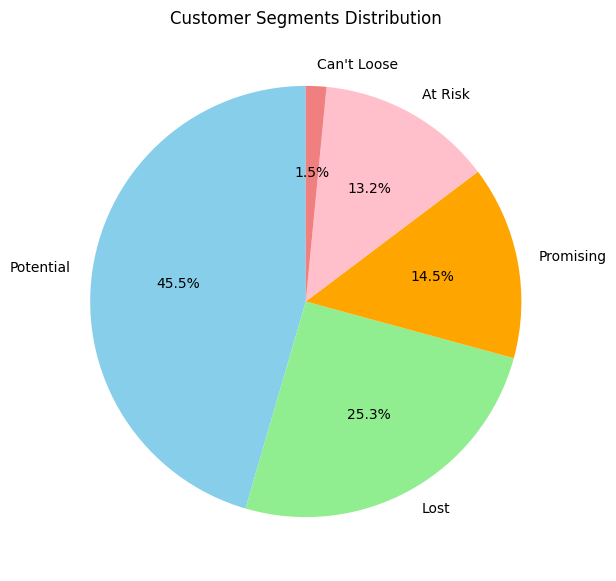

In [ ]:
#plot by segment
import matplotlib.pyplot as plt
# Plot the data by segment
# Plot pie chart for segments
segment_counts = rfm1['Segment'].value_counts()
plt.figure(figsize=(7, 7))
plt.pie(segment_counts, labels=segment_counts.index, autopct='%1.1f%%', startangle=90, colors=['skyblue', 'lightgreen', 'orange', 'pink', 'lightcoral'])
plt.title('Customer Segments Distribution')
plt.show()

In [3]:
#kmeans cluster
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Step 1: Scale the data (optional but recommended)
#rfm1 = rfm1.drop(columns=['Segment'])
scaler = StandardScaler()
df_scaled = scaler.fit_transform(rfm1)

# Step 2: Define and apply KMeans with 5 clusters
kmeans = KMeans(n_clusters=5, random_state=42)
kmeans.fit(df_scaled)

# Step 3: Assign the clusters back to the original dataset
rfm1['Cluster'] = kmeans.labels_

rfm1

NameError: name 'rfm1' is not defined

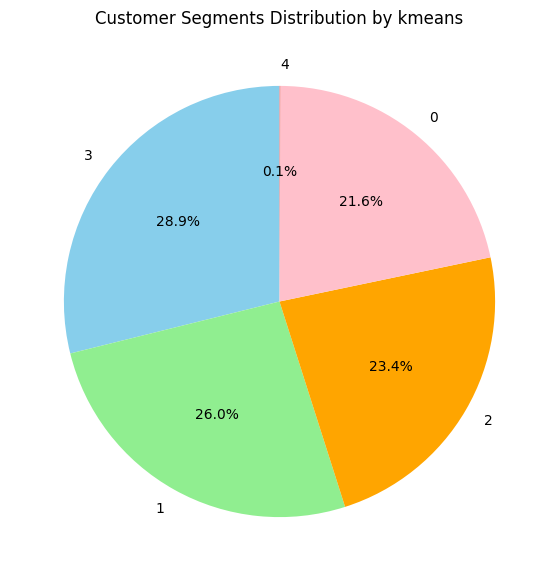

In [ ]:
segment_counts = rfm1['Cluster'].value_counts()
plt.figure(figsize=(7, 7))
plt.pie(segment_counts, labels=segment_counts.index, autopct='%1.1f%%', startangle=90, colors=['skyblue', 'lightgreen', 'orange', 'pink', 'lightcoral'])
plt.title('Customer Segments Distribution by kmeans')
plt.show()

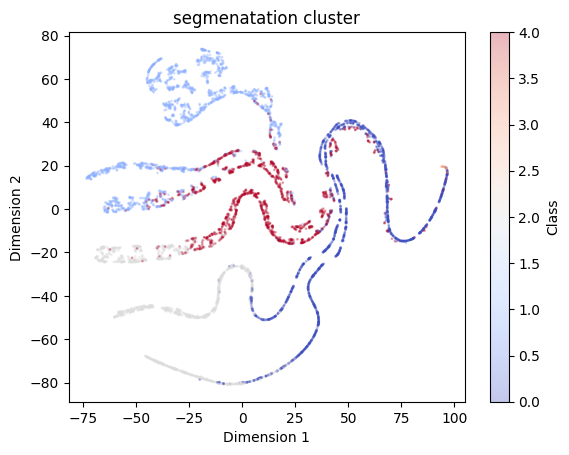

In [ ]:
# Plot tsne
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
X = rfm1.drop(columns=['Cluster'])
y=rfm1['Cluster']
features = X
labels =y

# Apply t-SNE for dimensionality reduction
tsne = TSNE(n_components=2, random_state=42)
embedded_features = tsne.fit_transform(features)

# Plotting the embedded features
plt.scatter(embedded_features[:, 0], embedded_features[:, 1], c=labels, cmap='coolwarm',s=1,alpha=0.3)
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('segmenatation cluster')
plt.colorbar(label='Class')
plt.show()

In [ ]:
#kmedoids
!pip install scikit-learn-extra
from sklearn_extra.cluster import KMedoids
kmedoids = KMedoids(n_clusters=5, random_state=42)
kmedoids.fit(df_scaled)
# Step 3: Assign the clusters back to the original dataset
rfm1['Cluster_m'] = kmedoids.labels_

rfm1

,Recency,Frequency,Monetary,RecencyScore,FrequencyScore,MonetaryScore,RFM_SCORE,Cluster,Cluster_m
Customer ID,,,,,,,,,
12346.0,319.0,17,77556.46,2,5,5,255,4,0
12347.0,33.0,7,5408.50,4,4,5,445,0,4
12348.0,69.0,5,2019.40,3,3,4,334,4,0
12349.0,12.0,5,4428.69,5,3,5,535,0,4
12350.0,304.0,1,334.40,2,1,2,212,1,3
...,...,...,...,...,...,...,...,...,...
18283.0,3.0,21,2528.65,5,5,4,554,0,4
18284.0,425.0,2,461.68,1,2,2,122,1,1
18285.0,654.0,1,427.00,1,2,2,122,1,1


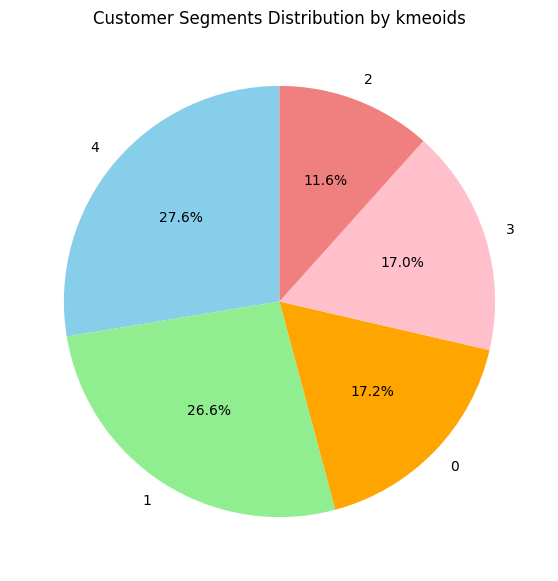

In [ ]:
segment_counts = rfm1['Cluster_m'].value_counts()
plt.figure(figsize=(7, 7))
plt.pie(segment_counts, labels=segment_counts.index, autopct='%1.1f%%', startangle=90, colors=['skyblue', 'lightgreen', 'orange', 'pink', 'lightcoral'])
plt.title('Customer Segments Distribution by kmeoids')
plt.show()

In [ ]:
!pip install fuzzy-c-means

In [ ]:
from fcmeans import FCM
fcm = FCM(n_clusters=5)
fcm.fit(df_scaled)
# Get the fuzzy cluster labels (hard clustering)
fuzzy_labels = fcm.predict(df_scaled)
# Add fuzzy labels to the original DataFrame
rfm1['Fuzzy_Cluster'] = fuzzy_labels

rfm1

,Recency,Frequency,Monetary,RecencyScore,FrequencyScore,MonetaryScore,RFM_SCORE,Cluster,Cluster_m,Fuzzy_Cluster
Customer ID,,,,,,,,,,
12346.0,319.0,17,77556.46,2,5,5,255,4,0,0
12347.0,33.0,7,5408.50,4,4,5,445,0,4,2
12348.0,69.0,5,2019.40,3,3,4,334,4,0,0
12349.0,12.0,5,4428.69,5,3,5,535,0,4,2
12350.0,304.0,1,334.40,2,1,2,212,1,3,4
...,...,...,...,...,...,...,...,...,...,...
18283.0,3.0,21,2528.65,5,5,4,554,0,4,2
18284.0,425.0,2,461.68,1,2,2,122,1,1,1
18285.0,654.0,1,427.00,1,2,2,122,1,1,1


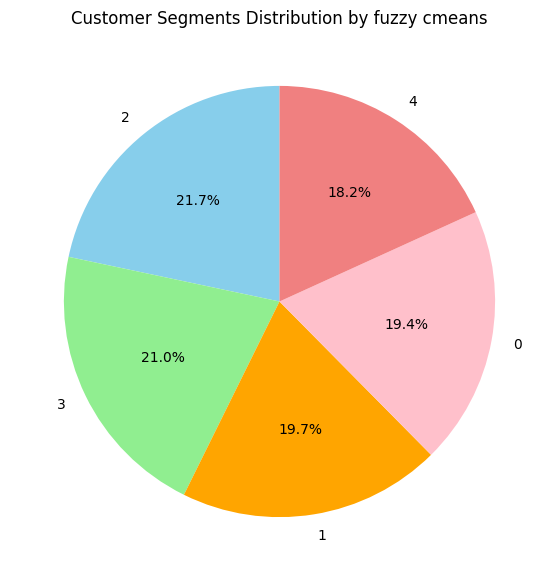

In [ ]:
segment_counts = rfm1['Fuzzy_Cluster'].value_counts()
plt.figure(figsize=(7, 7))
plt.pie(segment_counts, labels=segment_counts.index, autopct='%1.1f%%', startangle=90, colors=['skyblue', 'lightgreen', 'orange', 'pink', 'lightcoral'])
plt.title('Customer Segments Distribution by fuzzy cmeans')
plt.show()

In [ ]:
# Merge the segment column with the main data on 'Customer ID'
data = data[~data["Invoice"].str.contains("C", na = False)]
data.loc[:, 'InvoiceDate']=pd.to_datetime(data.loc[:, 'InvoiceDate'], format='%d.%m.%Y %H:%M')
merged_data = pd.merge(data, rfm1['Cluster'], on='Customer ID', how='left')
merged_data



,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Cluster
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,0
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,0
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,0
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,0
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,0
...,...,...,...,...,...,...,...,...,...
793375,580501,23284,DOORMAT KEEP CALM AND COME IN,2,2011-12-04 13:00:00,8.25,14546.0,United Kingdom,1
793376,580501,22507,MEMO BOARD RETROSPOT DESIGN,3,2011-12-04 13:00:00,4.95,14546.0,United Kingdom,1
793377,580502,22469,HEART OF WICKER SMALL,3,2011-12-04 13:15:00,1.65,16931.0,United Kingdom,1
793378,580502,23489,VINTAGE BELLS GARLAND,2,2011-12-04 13:15:00,2.89,16931.0,United Kingdom,1


In [ ]:
data_cluster_3=merged_data[merged_data['Cluster']==3]
# Set 'Date' as the index
data_cluster_3.set_index('InvoiceDate', inplace=True)

# Resample by semester (6 months) and sum only the 'Price' column
#semester_price_sum = data_cluster_3['Price'].resample('1W').sum()
#semester_price_sum = data_cluster_3.groupby(data_cluster_2.index)['InvoiceNo'].nunique().resample('1M').count()
#add coloumn sum the price for arimax
semester_price_sum = data_cluster_3.resample('1M').agg({
    'Invoice': pd.Series.nunique,  # Count unique invoices
    'Price': 'sum'                   # Sum of prices
})


# Print the result
semester_price_sum

,Invoice,Price
InvoiceDate,,
2009-12-31,190,11043.020
2010-01-31,136,7547.480
2010-02-28,144,7559.161
2010-03-31,192,10903.980
2010-04-30,148,9193.021
2010-05-31,157,9019.810
2010-06-30,159,11109.490
2010-07-31,147,12767.560
2010-08-31,132,7263.520


In [ ]:
#install auto arima
!pip install pmdarima

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


MAE: 8.429399030703598, MSE: 78.26895173219543, RMSE: 8.846974156862641, MAPE: 12.8807836997136%


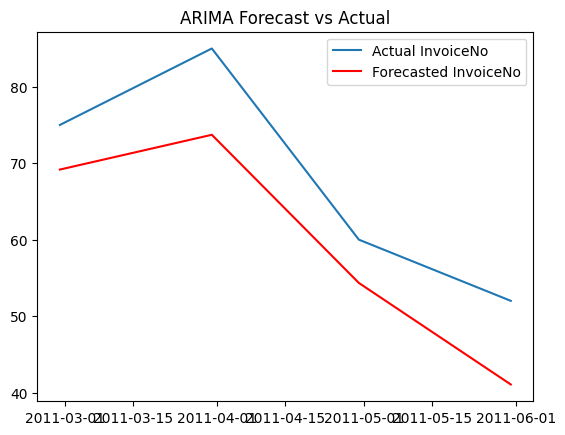

In [ ]:
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Example of splitting data into training and testing sets
train_size = int(len(semester_price_sum) * 0.8)
train, test = semester_price_sum.iloc[:train_size], semester_price_sum.iloc[train_size:]

# Set the target variable as 'InvoiceNo' and exogenous variable as 'Price'
y_train = train['Invoice']  # This is the target variable we want to forecast
y_test = test['Invoice']    # Test set target

exog_train = train['Price']
exog_test = test['Price']

# Fit the ARIMA model on the training set
model = ARIMA(y_train, order=(1, 1, 1),exog=exog_train)
model_fit = model.fit()


# Forecast for the length of the test set
forecast = model_fit.forecast(steps=len(y_test), exog=exog_test)

# Evaluate the forecast against the actual test set values (y_test)
mae = mean_absolute_error(y_test, forecast)
mse = mean_squared_error(y_test, forecast)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((y_test - forecast) / y_test)) * 100

print(f'MAE: {mae}, MSE: {mse}, RMSE: {rmse}, MAPE: {mape}%')

# Optionally, plot the forecast vs actuals
plt.plot(test.index, y_test, label='Actual InvoiceNo')
plt.plot(test.index, forecast, label='Forecasted InvoiceNo', color='red')
plt.title('ARIMA Forecast vs Actual')
plt.legend()
plt.show()

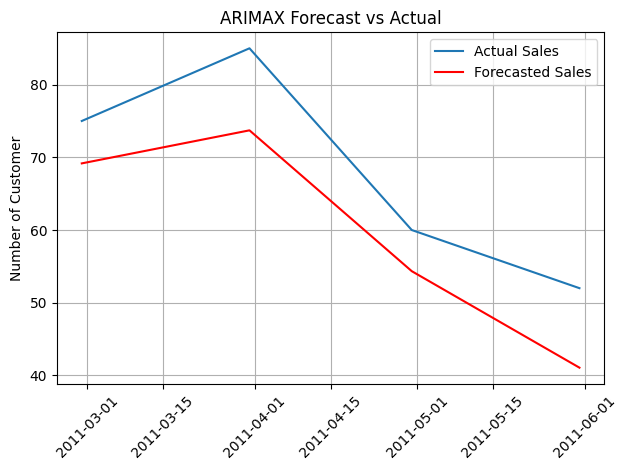

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates

# Plot the actual vs forecasted values
plt.plot(test.index, y_test, label='Actual Sales')
plt.plot(test.index, forecast, label='Forecasted Sales', color='red')

# Add a title and labels
plt.title('ARIMAX Forecast vs Actual')
plt.ylabel('Number of Customer')

# Rotate the x-axis labels for better readability
plt.xticks(rotation=45)

# Use a more readable y-axis formatting
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{int(x):,}'))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))


# Add a grid for better readability
plt.grid(True)

# Add a legend
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()

In [ ]:
data_cluster_3=merged_data[merged_data['Cluster']==3]
# Set 'Date' as the index
data_cluster_3.set_index('InvoiceDate', inplace=True)

# Resample by semester (6 months) and sum only the 'Price' column
semester_price_sum = data_cluster_3.groupby(data_cluster_3.index)['Invoice'].nunique().resample('1M').count()



# Print the result
semester_price_sum

,Invoice
InvoiceDate,
2009-12-31,186
2010-01-31,131
2010-02-28,143
2010-03-31,191
2010-04-30,147
2010-05-31,156
2010-06-30,158
2010-07-31,146
2010-08-31,133


Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=151.394, Time=0.27 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=156.262, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=157.534, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=153.298, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=184.871, Time=0.01 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=150.647, Time=0.19 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=148.960, Time=0.14 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=150.959, Time=0.12 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=152.817, Time=0.19 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=164.603, Time=0.04 sec

Best model:  ARIMA(2,0,0)(0,0,0)[0] intercept
Total fit time: 1.369 seconds
MAE: 106.69990261610968, MSE: 14957.520394788862, RMSE: 122.30094192110239, MAPE: 144.76932328175258%


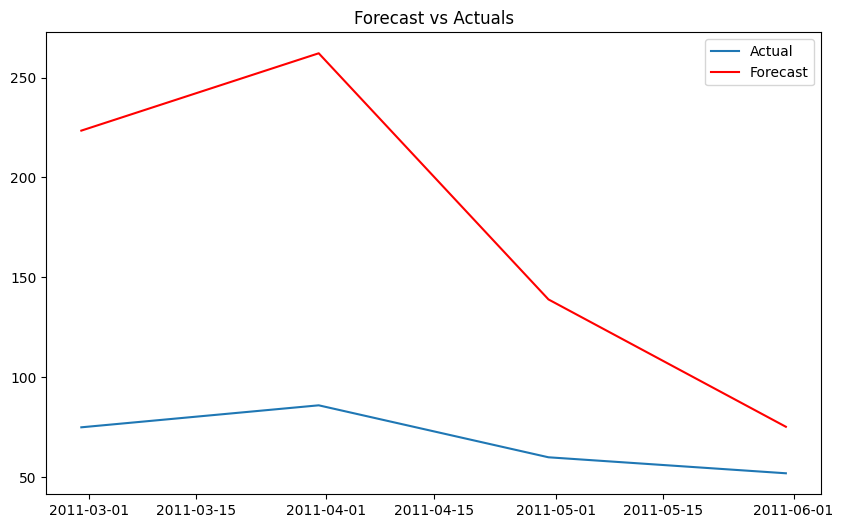

In [ ]:
import numpy as np  # Make sure to import NumPy
from pmdarima import auto_arima
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Example of splitting data into training and testing sets
train_size = int(len(semester_price_sum) * 0.8)
train, test = semester_price_sum.iloc[:train_size], semester_price_sum.iloc[train_size:]

# Fit the auto_arima model on the training set
model_fit = auto_arima(train, seasonal=True, trace=True)

# Forecast for the length of the test set
forecast = model_fit.predict(n_periods=len(test))

# Evaluate the forecast against the actual test set values (test)
mae = mean_absolute_error(test, forecast)
mse = mean_squared_error(test, forecast)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((test - forecast) / test)) * 100

# Print the evaluation metrics
print(f'MAE: {mae}, MSE: {mse}, RMSE: {rmse}, MAPE: {mape}%')

# Plot the forecast vs actual values
plt.figure(figsize=(10, 6))
plt.plot(test.index, test, label='Actual')
plt.plot(test.index, forecast, label='Forecast', color='red')
plt.legend()
plt.title('Forecast vs Actuals')
plt.show()

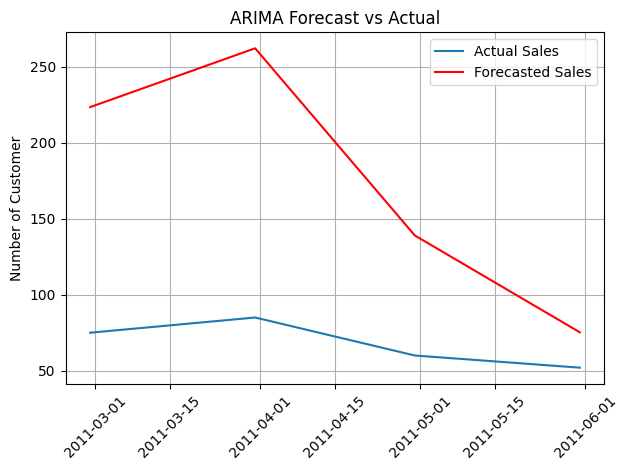

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates

# Plot the actual vs forecasted values
plt.plot(test.index, y_test, label='Actual Sales')
plt.plot(test.index, forecast, label='Forecasted Sales', color='red')

# Add a title and labels
plt.title('ARIMA Forecast vs Actual')
plt.ylabel('Number of Customer')

# Rotate the x-axis labels for better readability
plt.xticks(rotation=45)

# Use a more readable y-axis formatting
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{int(x):,}'))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))


# Add a grid for better readability
plt.grid(True)

# Add a legend
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()